## Import modules

In [82]:
import pandas as pd
import numpy as np
from scipy import stats
import re
import json
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from operator import itemgetter
pd.set_option('display.max_colwidth', 800)

START_DATE = "2020/"

## Import Data

In [174]:
path = r'/mnt/datastore/data/antivax/timelines' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    try: 
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)
    except Exception as e:
        print(filename, e)

tweets = pd.concat(li, axis=0, ignore_index=True)
tweets = tweets[~tweets['created_at'].isna()]
tweets['created_at'] = pd.to_datetime(tweets['created_at'])
tweets.head(3)

/mnt/datastore/data/antivax/timelines/MarteauOlivier.csv Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

/mnt/datastore/data/antivax/timelines/PRANEDOLLY.csv Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.



,tweet_id,user_id,user_name,followers,friends,user_location,likes,retweets,text,created_at,urls,in_reply_to_user_id,in_reply_to_screen_name,user_mentions,retweeted_status
0,1258508754573594625,364513528,LeHuffPost,1142746.0,2122,France,18,8.0,Roland-Garros va rembourser tous les billets https://t.co/1hah6Rr0Jr,2020-05-07 21:27:23+00:00,"[URL(URL=https://t.co/1hah6Rr0Jr, ExpandedURL=http://huffp.st/rHdHAT1)]",NaN,NaN,[],NaN
1,1258499371748003845,364513528,LeHuffPost,1142746.0,2122,France,0,2.0,Accueil prioritaire et groupes restreints: les modalités de réouverture des crèches le 11 mai https://t.co/Nb5VChe3ue,2020-05-07 20:50:06+00:00,"[URL(URL=https://t.co/Nb5VChe3ue, ExpandedURL=http://huffp.st/mLOPGPy)]",NaN,NaN,[],NaN
2,1258484958722691072,364513528,LeHuffPost,1142746.0,2122,France,10,7.0,Deux mois de confinement à la maison peuvent traumatiser les enfants mais aussi les adultes https://t.co/sWK2tkfbqU,2020-05-07 19:52:50+00:00,"[URL(URL=https://t.co/sWK2tkfbqU, ExpandedURL=http://huffp.st/4R7aDwD)]",NaN,NaN,[],NaN


In [178]:
# Filter to have the same scale
print(tweets.count())
tweets = tweets[(tweets['created_at'] < "2020-04-01") & (tweets['created_at'] > "2019-09-01")]
tweets.count()

tweet_id                   1511130
user_id                    1511130
user_name                  1511130
followers                  1511130
friends                    1511130
user_location              1083045
likes                      1511130
retweets                   1511130
text                       1511130
created_at                 1511130
urls                       1511130
in_reply_to_user_id         325884
in_reply_to_screen_name     325884
user_mentions              1511130
retweeted_status            522596
dtype: int64


tweet_id                   518711
user_id                    518711
user_name                  518711
followers                  518711
friends                    518711
user_location              376488
likes                      518711
retweets                   518711
text                       518711
created_at                 518711
urls                       518711
in_reply_to_user_id        119809
in_reply_to_screen_name    119809
user_mentions              518711
retweeted_status           180855
dtype: int64

## Clean Data

In [179]:
# Parse user mentions
tweets['user_mentions_id'] = tweets["user_mentions"].str.find("ID=([0-9]+),")
tweets['user_mentions_screen_name'] = tweets["user_mentions"].str.find("ScreenName=(\w+)\)")


In [180]:
# Parse retweets infos
tweets["retweeted_screen_name"] = tweets[~tweets["retweeted_status"].isna()].retweeted_status.apply(lambda x: json.loads(x)['user']['screen_name'])
tweets["retweeted_id"] = tweets[~tweets["retweeted_status"].isna()].retweeted_status.apply(lambda x: json.loads(x)['user']['id_str'])

In [181]:
# Convert Ids to numeric
tweets["in_reply_to_user_id"] = pd.to_numeric(tweets["in_reply_to_user_id"], errors='coerce')
tweets["retweeted_id"] = pd.to_numeric(tweets["retweeted_id"], errors='coerce')
tweets["user_mentions_id"] = pd.to_numeric(tweets["user_mentions_id"], errors='coerce')
tweets["user_id"] = pd.to_numeric(tweets["user_id"], errors='coerce')

In [182]:
# Get the interactions between the different users
def get_interactions(row):
    user = row["user_id"], row["user_name"]
    
    if user[0] is None:
        return (None, None), []
    
    interactions = set()
    interactions.add((row["in_reply_to_user_id"], row["in_reply_to_screen_name"]))
    interactions.add((row["retweeted_id"], row["retweeted_screen_name"]))
    interactions.add((row["user_mentions_id"], row["user_mentions_screen_name"]))
        
    interactions.discard((row["user_id"], row["user_name"]))
    interactions.discard((None, None))
    return user, interactions

In [183]:
TOP_USERS = 100
all_users = np.append(tweets.user_name,tweets.in_reply_to_screen_name)
all_users = np.append(all_users, tweets.retweeted_screen_name)
all_users = np.append(all_users, tweets.user_mentions_screen_name)
all_users = pd.DataFrame(all_users)
important_users = all_users[0].value_counts()[1:TOP_USERS]
important_users = list(important_users.keys())

In [184]:
seed_users = np.unique(tweets.user_name.values).tolist()
filter_users = list(set(seed_users) | set(important_users)) 
len(filter_users)

500

In [185]:
tweets_filtered = tweets[tweets.in_reply_to_screen_name.isin(filter_users) 
       | tweets.retweeted_screen_name.isin(filter_users)
       | tweets.user_mentions_screen_name.isin(filter_users)]
tweets_filtered = tweets_filtered.reset_index()
tweets_filtered = tweets_filtered.where((pd.notnull(tweets_filtered)), None)
tweets_filtered.shape[0]

97474

## Build the graph

In [186]:
graph = nx.Graph()
#graph = nx.DiGraph()
#graph.add_nodes_from(filter_users)
for index, tweet in tweets_filtered.iterrows():
    print("{}/{}\r".format(index, tweets_filtered.shape[0]), end="")
    user, interactions = get_interactions(tweet)
    user_id, user_name = user
    #tweet_id = tweet["tweet_id"]
    for interaction in interactions:
        int_id, int_name = interaction
        if(user_name in filter_users and int_name in filter_users):
            # Add or update node user
            if graph.has_node(user_name):
                graph.nodes[user_name]['weight'] += 1
            else:
                graph.add_node(user_name, weight=1)
            
            # Add or update node interaction
            if graph.has_node(int_name):
                graph.nodes[int_name]['weight'] += 1
            else:
                graph.add_node(int_name, weight=1)
            
            # Add or update edge user - interaction
            if graph.has_edge(user_name, int_name):
                graph[user_name][int_name]['weight'] += 1
            else:
                graph.add_edge(user_name, int_name, weight=1)

## Infos on the graph

In [187]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")

There are 474 nodes and 11948 edges present in the Graph


In [188]:
degrees = [val for (node, val) in graph.degree()]

print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")

The maximum degree of the Graph is 197
The minimum degree of the Graph is 1


In [189]:
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")

The graph is not connected


In [190]:
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")


There are 2 connected components in the Graph


In [201]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
largest_subgraph = max(connected_component_subgraphs(graph), key=len)

In [202]:
number_of_nodes = largest_subgraph.number_of_nodes()
number_of_edges = largest_subgraph.number_of_edges()
print(f"There are {number_of_nodes} nodes and {number_of_edges} \
edges present in the largest component of the Graph")

There are 473 nodes and 11947 edges present in the largest component of the Graph


In [203]:
if nx.is_connected(largest_subgraph):
    print("The graph is connected")
else:
    print("The graph is not connected")


The graph is connected


In [ ]:
#print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
#print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")

In [ ]:
#print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
#print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

In [204]:
#largest_subgraph = graph
import heapq
top = 5
graph_centrality = nx.degree_centrality(largest_subgraph)
max_de = heapq.nlargest(top,graph_centrality.items(), key=itemgetter(1))
#max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(largest_subgraph)
max_clo = heapq.nlargest(top,graph_closeness.items(), key=itemgetter(1))
#max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)
max_bet = heapq.nlargest(top,graph_betweenness.items(), key=itemgetter(1))
#max_bet = max(graph_betweenness.items(), key=itemgetter(1))

print("Centrality Degree:")
print(max_de)
print("Closeness Centrality:")
print(max_clo)
print("Betweenness Centrality:")
print(max_bet)

#print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
#print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

Centrality Degree:
[('DamienRieu', 0.4173728813559322), ('SJallamion', 0.4152542372881356), ('Valeurs', 0.3559322033898305), ('JeanMessiha', 0.3516949152542373), ('patrick_edery', 0.3453389830508475)]
Closeness Centrality:
[('SJallamion', 0.6194225721784777), ('DamienRieu', 0.6169934640522876), ('JeanMessiha', 0.5877957658779577), ('patrick_edery', 0.5841584158415841), ('Valeurs', 0.5805658056580566)]
Betweenness Centrality:
[('DamienRieu', 0.02652575718752008), ('realDonaldTrump', 0.02400513982452001), ('ChWilhou', 0.023713007420318365), ('OlivierFraudeau', 0.022833939021239206), ('SJallamion', 0.019711613207057558)]


In [205]:
node_and_degree = largest_subgraph.degree()
colors_central_nodes = 'red'
central_nodes =  list(list(zip(*max_de))[0])#['tprincedelamour']

In [206]:
pos = nx.spring_layout(largest_subgraph)

In [207]:
nodes_weights = list(list(zip(*list(largest_subgraph.nodes.data('weight'))))[1])

In [208]:
seed_users = list(filter(lambda node: node in list(largest_subgraph.nodes()), seed_users))
important_users = list(filter(lambda node: node in list(largest_subgraph.nodes()) and node not in seed_users, important_users))

## Community Detection

In [199]:
# Compute community detection
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms import community

numberOfClusters = 5

communities_generator = community.girvan_newman(largest_subgraph)
for i in range(numberOfClusters - 1):
    next_level_communities = next(communities_generator)
communities = sorted(map(sorted, next_level_communities))
len(communities)

[['19h30RTS',
  '1RiposteLaique',
  '20minutesOnline',
  '24heuresch',
  '4h6r4kpf',
  'AQuatennens',
  'Abdou64533132',
  'Actu17',
  'AigleRoyal06',
  'Al_Bundy_lro',
  'AlainSoralOffic',
  'AldoSterone111',
  'AlexDevecchio',
  'Alexis_Cossette',
  'AllPourLaFrance',
  'AnaLignier',
  'AndreaKotarac',
  'AnneFarmer65',
  'AnneTP33',
  'AntiChemtrails',
  'AntoineBaudino',
  'Aramisunchained',
  'ArianeWalter',
  'Arille_Tella',
  'BBrocard',
  'BVoltaire',
  'BarackObama',
  'BeatriceMarty',
  'Bernard_Rappaz',
  'BilgerPhilippe',
  'BlaiseElise',
  'BorisJohnson',
  'BoschettiSteen',
  'BouloGiletJaune',
  'BoussageonR',
  'Breizh_Info',
  'Brevesdepresse',
  'BrunoLeMaire',
  'BrunoRetailleau',
  'BuchardD',
  'CCastaner',
  'CHmarmotte',
  'CRE_SciencesPo',
  'CWeillRaynal',
  'C_Barbier',
  'CapuPatriote',
  'CatherineRiva',
  'Causeur',
  'CedreHumanitrad',
  'CercleVoltaire',
  'CerdagneFrance',
  'CerveauxNon',
  'ChLECHEVALIER',
  'ChWilhou',
  'CheeperOff',
  'Christheswiss

In [209]:
from networkx.algorithms.community import greedy_modularity_communities
communities = greedy_modularity_communities(graph, weight='weight')
len(communities)

129

In [221]:
from networkx.algorithms.community import asyn_lpa_communities
communities = list(asyn_lpa_communities(graph, weight='weight'))
len(communities)

31

In [236]:
# Add community number to node
for node in largest_subgraph.nodes():
    largest_subgraph.nodes[node]['group'] = next(i for i,v in enumerate(communities) if node in v)


## Visualize 

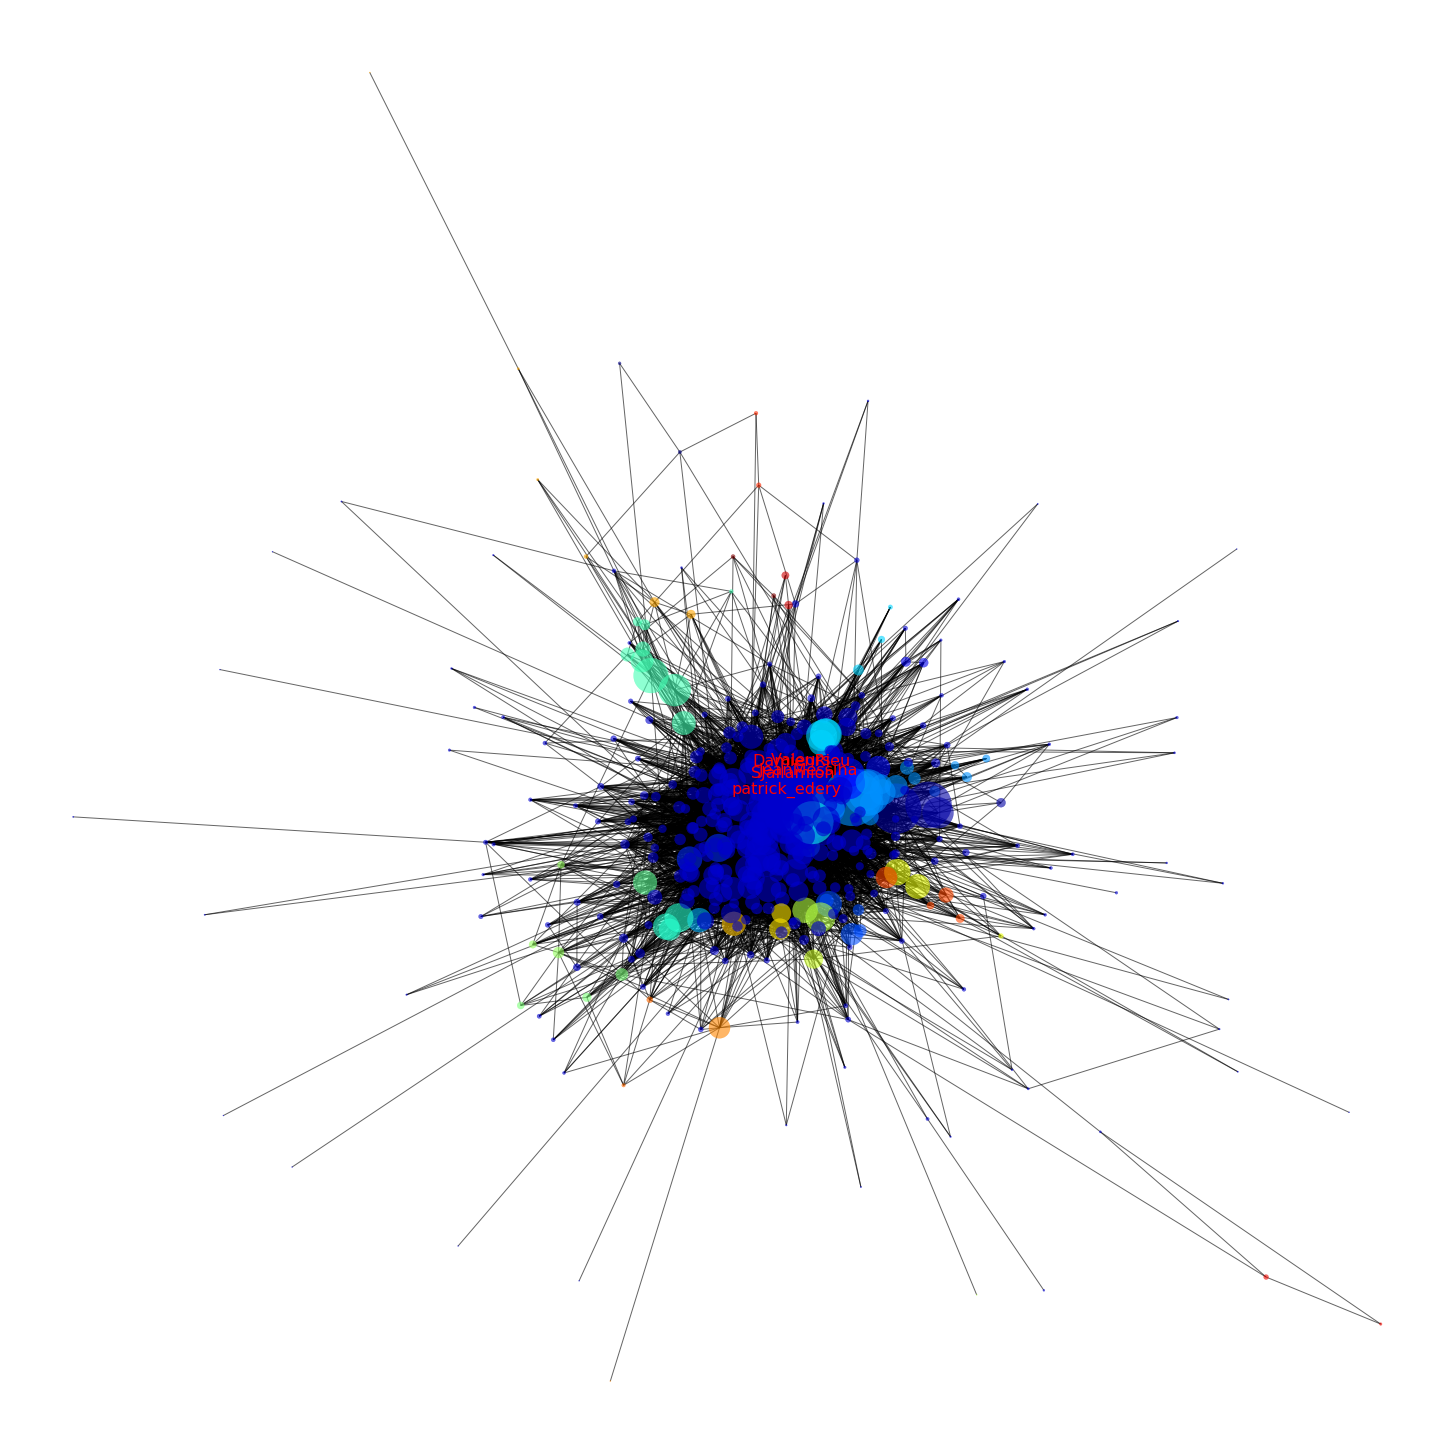

In [222]:
import matplotlib
plt.figure(figsize = (20,20))

groups = range(len(communities))
nodes = largest_subgraph.nodes()
colors = [next(i for i,v in enumerate(communities) if n in v) for n in nodes]

nx.draw(largest_subgraph, font_weight='bold', pos=pos, node_color=colors, cmap=plt.cm.jet, edge_color="black", linewidths=0.3, node_size=nodes_weights, alpha=0.6, with_labels=False)
#nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=300, node_color=colors_central_nodes, with_labels=True)
'''
nodes_colors = matplotlib.cm.ScalarMappable(
      norm = matplotlib.colors.Normalize(0, len(communities)), 
      cmap = plt.cm.PiYG)
for i, c in enumerate(communities):
    nodes_weights = list(list(zip(*list(graph.nodes.data('weight'))))[1])
    nx.draw_networkx_nodes(largest_subgraph,pos,
                       nodelist=list(c),
                       node_color=nodes_colors.to_rgba(i),
                       #cmap=plt.cm.PiYG,
                       node_size=nodes_weights,
                       alpha=0.8)
                       
                       
    
nx.draw_networkx_edges(largest_subgraph,pos,alpha=0.5)
'''

labels = {}    
for node in largest_subgraph.nodes():
    if node in central_nodes:
        labels[node] = node
pos_higher = {}
y_off = 0.05 

for k, v in pos.items():
    pos_higher[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(largest_subgraph,pos_higher,labels,font_size=16,font_color='r')


#nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=seed_users, node_size=10, node_color='red', with_labels=True)
#nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=important_users, node_size=10, node_color='blue', with_labels=True)

#plt.savefig('graphfinal.png')
plt.show()

In [173]:
h,a=nx.hits(largest_subgraph, max_iter=1000)
print(h)
print(a)

{'Predatoutheures': 0.000155321556454586, '20Minutes': 0.0, 'LeHuffPost': 0.0, 'le_Parisien': 0.0, 'BFMTV': 0.0, 'LouisRielFrance': 2.6723795966458524e-05, 'CNEWS': 0.0, 'Le_Figaro': 5.618439969636468e-07, 'franceinfo': 0.0, 'lemondefr': 0.0, 'MarianneleMag': 3.6175705619772025e-07, 'afpfr': 0.0, '_Stalker_69_': 0.00035546814265545473, 'nadine__morano': 0.00012415691879142458, 'SOSCdOrient': 4.504021290971757e-06, 'Europe1': 0.0, 'PoliceNationale': 5.31678645830517e-06, 'DLF_Officiel': 7.943222561434644e-05, 'Place_Beauvau': 1.548357478109838e-05, 'W_Alhusseini': 4.149790765245043e-07, '__Verlaine__': 0.0011735818511694448, 'lobs': 1.5422948037484585e-07, 'EmmanuelMacron': 1.075416500835673e-06, 'SniperDeDroite': 9.301229326171332e-06, 'LEXPRESS': 4.4193456468059545e-08, 'LesEchos': 0.0, 'EnModeMacaron': 1.7835474663313362e-05, 'gouvernementFR': 3.1315657367399014e-05, 'LCP': 5.3033849466576874e-08, 'franceculture': 1.1682572161459732e-08, 'adrenaline1001': 0.00027490821878817885, 'lib

## Export to json

In [107]:
data_set = {"nodes": [{"id":node[0], "name":node[0], "val":node[1]['weight'], "val":node[1]['weight']} for node in list(largest_subgraph.nodes(data=True))], 
            "links": [{"source":node[0], "target":node[1], "val":node[2]['weight']} for node in list(largest_subgraph.edges(data=True))]}

with open('interaction_graph.json', 'w') as outfile:
    json.dump(data_set, outfile)